In [313]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tempfile
from matplotlib import pyplot as plt




batch_size = 32
img_height = 300
img_width = 300
data_dir ="Number"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 90 files belonging to 5 classes.
Using 72 files for training.
Found 90 files belonging to 5 classes.
Using 18 files for validation.


In [314]:
class_names = train_ds.class_names
print(class_names)

['Decimal Number', 'Fraction Number', 'Negative Number', 'Percentage Number', 'Positive Number']


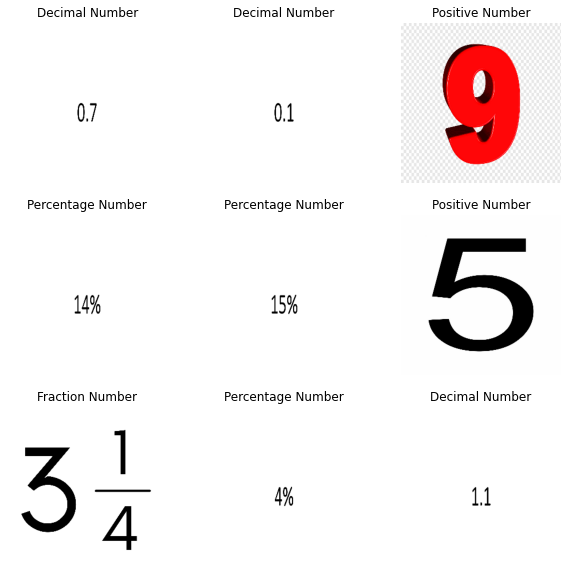

In [315]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [316]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [317]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [318]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [319]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [320]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_35 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 75, 75, 64)      

In [321]:
# import os
# # import cv2
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                index=f.rfind('.')
                ext=f[index+1:].lower()
                if ext not in ext_list:
                    print('file ', f_path, ' has an invalid extension ', ext)
                    bad_ext.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'C:\Users\Liyana\Desktop\python'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  -p
processing class directory  1.png
*** WARNING*** you have files in  C:\Users\Liyana\Desktop\python  it should only contain sub directories
processing class directory  35.png
*** WARNING*** you have files in  C:\Users\Liyana\Desktop\python  it should only contain sub directories
processing class directory  Number
file  C:\Users\Liyana\Desktop\python\Number\Decimal Number  has an invalid extension  decimal number
*** fatal error, you a sub directory  Decimal Number  in class directory  Number
file  C:\Users\Liyana\Desktop\python\Number\Fraction Number  has an invalid extension  fraction number
*** fatal error, you a sub directory  Fraction Number  in class directory  Number
file  C:\Users\Liyana\Desktop\python\Number\Negative Number  has an invalid extension  negative number
*** fatal error, you a sub directory  Negative Number  in class directory  Number
file  C:\Users\Liyana\Desktop\python\Number\Percentage Number  has an invalid extension  percentage num

In [323]:
epochs=20
model.fit(train_ds,validation_data=val_ds,epochs=epochs)


#Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

Epoch 1/20
3/3 [==============================] - 4s 1s/step - loss: 1.6303 - accuracy: 0.3611 - val_loss: 1.6470 - val_accuracy: 0.2353
Epoch 2/20
3/3 [==============================] - 4s 2s/step - loss: 1.4428 - accuracy: 0.4167 - val_loss: 1.6616 - val_accuracy: 0.2353
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 1.2481 - accuracy: 0.5000 - val_loss: 1.6030 - val_accuracy: 0.2353
Epoch 4/20
3/3 [==============================] - 3s 907ms/step - loss: 1.0316 - accuracy: 0.5833 - val_loss: 1.4842 - val_accuracy: 0.2941
Epoch 5/20
3/3 [==============================] - 3s 914ms/step - loss: 0.8382 - accuracy: 0.6250 - val_loss: 1.7330 - val_accuracy: 0.2941
Epoch 6/20
3/3 [==============================] - 3s 910ms/step - loss: 0.6086 - accuracy: 0.6944 - val_loss: 1.8911 - val_accuracy: 0.5882
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 0.4438 - accuracy: 0.8611 - val_loss: 2.7130 - val_accuracy: 0.3529
Epoch 8/20
3/3 [================

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [324]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_35 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 75, 75, 64)      

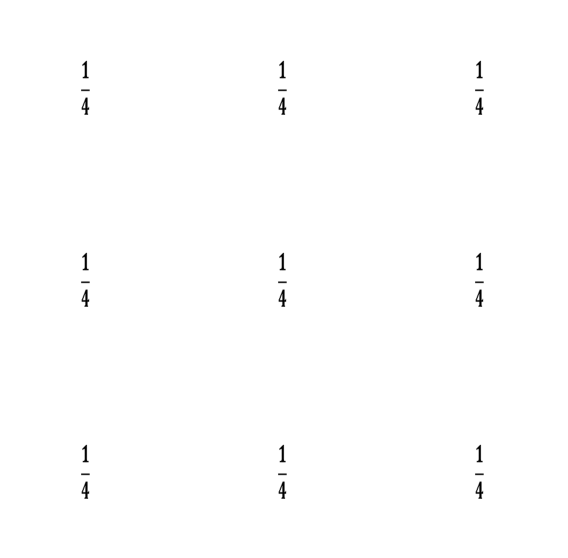

In [325]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [326]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_32 (Sequential)  (None, 300, 300, 3)       0         
                                                                 
 rescaling_36 (Rescaling)    (None, 300, 300, 3)       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_70 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                

In [332]:
img = keras.preprocessing.image.load_img(
    "35.png", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 51ms/step
This image most likely belongs to Fraction Number with a 99.78 percent confidence.
